In [1]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from typing import Tuple, List
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt

import random

In [ ]:
parent_dir = os.path.dirname(os.getcwd())  # Get parent of current working directory

def load_models():

    model_path = os.path.join(parent_dir, 'Models/yardage_model.pkl')
    with open(model_path, 'rb') as f:
        yardage_model = pickle.load(f)
    
    model_path = os.path.join(parent_dir, 'Models/touchdown_model.pkl')
    with open(model_path, 'rb') as f:
        touchdown_model = pickle.load(f)

    return yardage_model, touchdown_model



In [3]:
YEARS = [2023,2024]

# %%
data_all = pd.DataFrame()

def calculate_seconds(row):
    if row['qtr'] != 5:
        return 3600 - row['game_seconds_remaining']
    else:
        return 600 - row['game_seconds_remaining'] + 3600


def get_quarter_value(dataf):
    if 'END QUARTER' in dataf['desc']:
        return dataf['level_0']
    else:
        return None

for i in YEARS:  
    i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(i) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

    data_all = pd.concat([data_all,i_data])

ppr = 1

data = data_all.loc[data_all.season_type=='REG']
#data = data_all.loc[(data_all.play_type.isin(['no_play','pass','run'])) & (data_all.epa.isna()==False)]
#data.loc[data['pass']==1, 'play_type'] = 'pass'
#data.loc[data.rush==1, 'play_type'] = 'run'
data.reset_index(drop=True, inplace=True)
data['turnover'] = data['interception'] + data['fumble_lost']
data = data.dropna(subset=['posteam'])
data['inside_10'] = (data['yardline_100'] < 10).astype(int)
data['20+_play'] = (data['yards_gained'] > 19).astype(int)
data['short_pass'] = (data['air_yards'] < 10).astype(int)
data['medium_pass'] = ((data['air_yards'] > 9)&(data['air_yards']<20)).astype(int)
data['deep_pass'] = (data['air_yards'] > 19).astype(int)
data['end_zone_target'] = (data['yardline_100'] - data['air_yards']) <= 0
data['fantasy_points'] = (
    data['complete_pass'] * ppr +          # 1 point per completion
    data['touchdown'] * 6 +           # 6 points per touchdown
    data['yards_gained'] * 0.1        # 0.1 points per yard gained
)
data['distance_to_EZ_after_target'] = data['yardline_100'] - data['air_yards']

C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2688378313.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['turnover'] = data['interception'] + data['fumble_lost']
C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2688378313.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['turnover'] = data['interception'] + data['fumble_lost']
C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2688378313.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

In [4]:
def total_finder(home_or_away,home_total,away_total):
    if home_or_away == 'home':
        total = home_total
    else:
        total = away_total 
    return total

In [5]:
    data.reset_index(drop=True, inplace=True)

    data = data[data['two_point_attempt']==0]

    data['total_plays'] = data['pass'] + data['rush']

    # derive implied team total from betting market data
    data['home_implied_total'] = abs(data['total_line'] / 2 + data['spread_line'] / 2)
    data['away_implied_total'] = abs(data['total_line'] / 2 - data['spread_line'] / 2)
    data = data[(data['play_type']=='pass')|(data['play_type']=='run')]
    # Use list comprehension with zip for more efficient row-wise operations
    data['implied_posteam_total'] = [
    total_finder(has_ball, home_number, away_number)
        for has_ball, home_number, away_number in zip(data['posteam_type'], data['home_implied_total'], data['away_implied_total'])
]


C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2268842550.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['total_plays'] = data['pass'] + data['rush']
C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2268842550.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['home_implied_total'] = abs(data['total_line'] / 2 + data['spread_line'] / 2)
C:\Users\src15\AppData\Local\Temp\ipykernel_29764\2268842550.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [6]:
    
    # we only want throws to a receiver, aka plays with air yardage (no running plays, sacks, throwaways etc.)
    throws = data[data['air_yards'].notna()]

    throws = throws[throws['receiver_player_name'].notna()]
    throws = throws[throws['pass_location'].notna()]

    
    df = throws[['receiver_player_name','receiver_player_id','posteam','pass','cp','game_id','complete_pass','inside_10','air_yards','yardline_100','ydstogo','implied_posteam_total','yards_gained','fantasy_points','pass_touchdown','down','pass_location','week','season','home_implied_total','away_implied_total','posteam_type','qb_hit','end_zone_target', 'distance_to_EZ_after_target','yards_after_catch']]


In [7]:
with open('pass_volume_model.pkl', 'rb') as file:
    pass_volume_model = pickle.load(file)

In [8]:

# Create the buckets with new ranges
def bucket_air_yards(df):
    """
    Buckets the air_yards column into predefined ranges.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with an 'air_yards' column.

    Returns:
    - pd.DataFrame: DataFrame with a new 'air_yards_bucket' column.
    """
    bins = [-float('inf'), 5, 11, 16, 21, float('inf')]
    labels = ['<5 yards', '5-10 yards', '11-15 yards', '16-20 yards', '21+ yards']
    
    df['air_yards_bucket'] = pd.cut(df['air_yards'], 
                                    bins=bins, 
                                    labels=labels, 
                                    right=False)  # Use right=False to make the intervals left-inclusive
    return df


C:\Users\src15\AppData\Local\Temp\ipykernel_29764\532177772.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['air_yards_bucket'] = pd.cut(df['air_yards'],


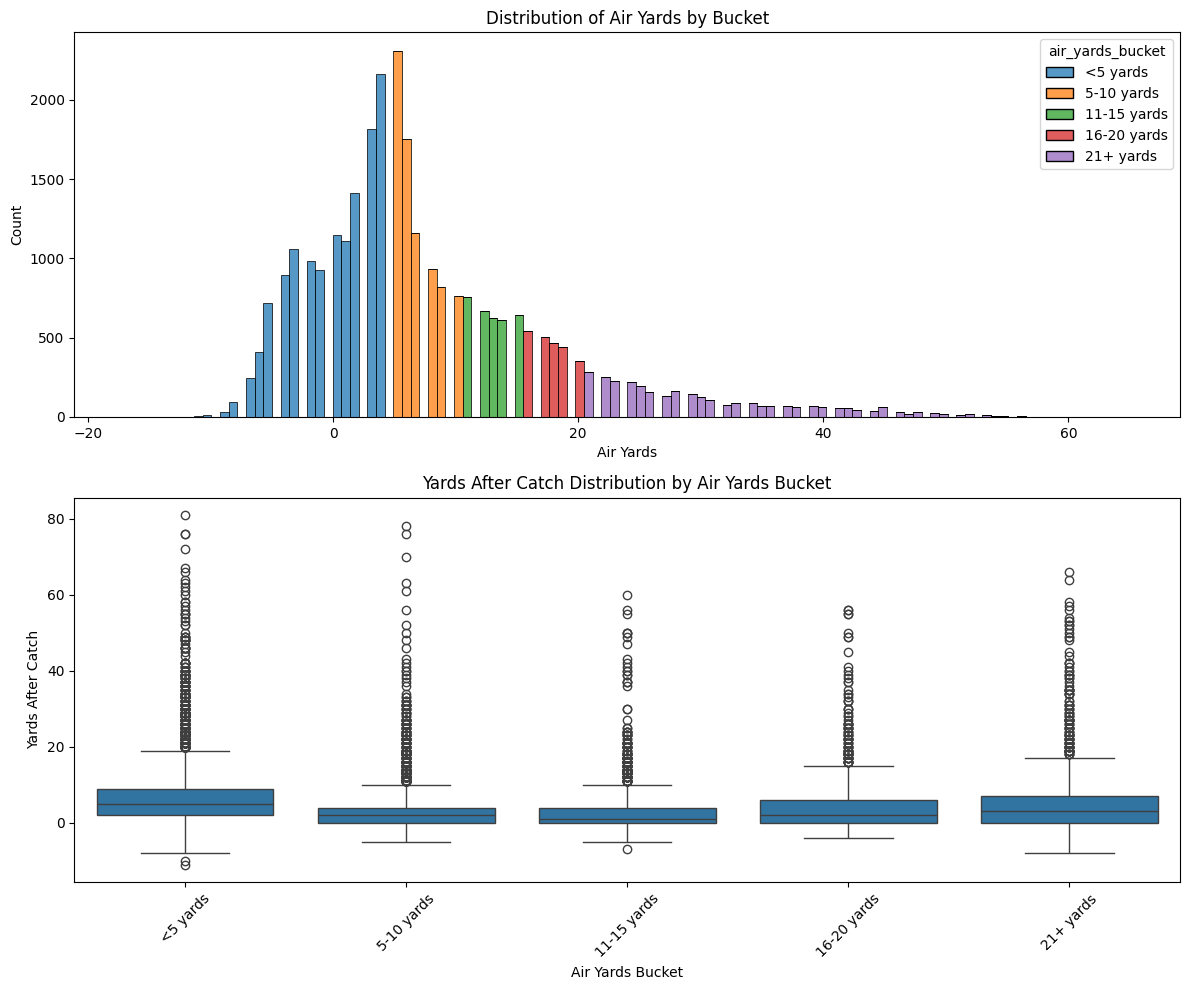

In [9]:

# And here's the same visualization function to use with the new buckets
def plot_yards_distributions(df):
    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot air_yards distribution
    sns.histplot(data=df, 
                x='air_yards',
                hue='air_yards_bucket',
                multiple="stack",
                ax=ax1)
    ax1.set_title('Distribution of Air Yards by Bucket')
    ax1.set_xlabel('Air Yards')
    ax1.set_ylabel('Count')
    
    # Plot yards_after_catch distribution
    sns.boxplot(data=df,
                x='air_yards_bucket',
                y='yards_after_catch',
                ax=ax2)
    ax2.set_title('Yards After Catch Distribution by Air Yards Bucket')
    ax2.set_xlabel('Air Yards Bucket')
    ax2.set_ylabel('Yards After Catch')
    ax2.tick_params(axis='x', rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage:
df = bucket_air_yards(df)
plot_yards_distributions(df)

In [10]:
bucket_mean_comp = {
    bucket: df[df['air_yards_bucket'] == bucket]['complete_pass'].mean()
    for bucket in df['air_yards_bucket'].unique()
}


bucket_mean_gain = {
    bucket: df[(df['air_yards_bucket'] == bucket)&(df['complete_pass']==1)]['yards_gained'].mean()
    for bucket in df['air_yards_bucket'].unique()
}

In [12]:
frequency = df['air_yards_bucket'].value_counts()


frequency = frequency / frequency.sum()

# Create the simulation function
def simulate_air_yards_bucket(frequency):
    return np.random.choice(frequency.index, p=frequency.values)


def completion_counter(air_yards_bucket):
    cp = bucket_mean_comp[air_yards_bucket]
    rng = random.random()
    if rng<= cp:
        return 1
    else:
        return 0
    
#def yards_calculator(air_yards_bucket):







In [13]:
def target_simulator(player):
    frequency = df[df['receiver_player_name']==player]['air_yards_bucket'].value_counts()
    #print(frequency)
    frequency = frequency / frequency.sum()
    bucket = simulate_air_yards_bucket(frequency)
    
    catch = completion_counter(bucket)

    if catch == 1:
        yards = bucket_mean_gain[bucket]
    else:
        yards = 0 
        


    return catch, yards



In [15]:
test_df = pd.DataFrame()
test_df['bucket'] = bucket_
test_df['catch'] = catch_
test_df['yards'] = yardage_

In [16]:
def game_sim(team_attempts, target_share,player_name):
    targets = 0
    catches = 0
    yards = 0
    
    for snap in range(0,team_attempts):
        open = random.random()
        if open > target_share:
            pass
        else:
            targets += 1
            c, y = target_simulator(player_name)
            catches += c
            yards += y
    return targets, catches, yards


        #target_simulator(player_name)

In [17]:
def percentage_above_threshold(df, column, threshold):
    """
    Calculates the percentage of values in a DataFrame column above a given threshold.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to analyze.
    - threshold (float): The value to compare against.
    
    Returns:
    - float: The percentage of values above the threshold.
    """
    total_values = len(df[column])
    values_above_threshold = (df[column] > threshold).sum()
    percentage = (values_above_threshold / total_values) * 100
    return percentage


In [44]:
yardage_ = []
catch_ = []
targets_ = []

for x in range(0,1000):
    
    t, c, y = game_sim(32, .18, 'C.Tillman')
    targets_.append(t)
    yardage_.append(y)
    catch_.append(c)





In [45]:
result_df = pd.DataFrame()

result_df['targets'] = targets_
result_df['receptions'] = catch_
result_df['yards'] = yardage_

In [46]:
result_df['yards'].median()

45.690053603946964

In [47]:
threshold = 40.5
result = percentage_above_threshold(result_df, 'yards', threshold)
print(f"Percentage of values above {threshold}: {result:.2f}%")

Percentage of values above 40.5: 58.30%
